In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw, rdprops, rdcompare, rdconvert

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty, abstractstaticmethod
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

## Defining Paths and PolymerManagers

In [37]:
# Data file directories
data_dir = Path('data_for_paper')

colina_dir = data_dir / 'colina_data'

openff_dir = data_dir / 'openff_data'
openff_dir.mkdir(exist_ok=True)

combined_dir = data_dir / 'combined_data'
combined_dir.mkdir(exist_ok=True)

# Plot directories
fig_dir  = Path('figures_for_paper')

plot_prop_dir = fig_dir / 'property_plots'
plot_prop_dir.mkdir(exist_ok=True)

# Polymer collections
# COLL_PATH = Path('Collections')
COLL_PATH = Path('Reruns')

src_mgr   = PolymerManager(COLL_PATH / 'water_soluble_polymers')
redux_mgr = PolymerManager(COLL_PATH / 'water_soluble_reduced')
conf_mgr  = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
equil_mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')

## Measuring sizes of reduced and full-size chains

In [3]:
size_dir = data_dir / 'chain_sizes'
size_dir.mkdir(exist_ok=True)

# Producing atom and monomer number counts
for targ_mgr in (redux_mgr, src_mgr):
    size_dict = {}
    for mol_name, polymer in targ_mgr.polymers.items():
        SMARTS = polymer.monomer_info.SMARTS
        DOP = monomer.estimate_DOP_upper(SMARTS, min_chain_len=polymer.n_atoms)
        N = monomer.estimate_chain_len(SMARTS, DOP=DOP)
        assert(N == polymer.n_atoms)

        size_dict[mol_name] = {
            'N_atoms' : N,
            'N_monomers' : DOP
        }
    size_table = pd.DataFrame.from_dict(size_dict, orient='index')
    size_table.to_csv(size_dir / f'{targ_mgr.collection_dir.name}_sizes.csv')

## Collating shape property data from simulation and Colina paper

In [4]:
# Extracting high-dimensional data "cube" of observable averages for all replicates
full_prop_data = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
full_rdf_data  = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))

for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs_list:
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)
        traj = polymer.load_traj(sim_dir, remove_solvent=True)

        # collating shape properties
        time_data = pd.read_csv(sim_paths.time_data)
        # time_data = trajectory.acquire_time_props(traj, time_points=sim_params.time_points)
        time_steps, time_samples = trajectory.props_to_plot_data(time_data)
        for prop_name, time_series in time_samples.items():
            full_prop_data[polymer.base_mol_name][sim_params.charge_method][prop_name].append(time_series.mean())

        # collating radial distribution functions
        # rdf_data = pd.read_csv(sim_paths.spatial_data)
        rdf_data = trajectory.acquire_rdfs(traj, min_rad=0.2, max_rad=1.2, rad_unit=nanometer)
        rdf_data.to_csv(sim_paths.spatial_data) # overwrite rdfs with correct raii ranges
        radii, rdfs = trajectory.rdfs_to_plot_data(rdf_data)

        for atom_pair, rdf in rdfs.items():
            full_rdf_data[polymer.base_mol_name][sim_params.charge_method][atom_pair].append(rdf)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      35.436  38.089  34.219  1.00  0.00              , ATOM    422  H   RES A   1      12.560  24.483  14.106  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning: WARNING: two consecutive residues with same number (HETATM  423  H1  HOH A   1      35.436  38.089  34.219  1.00  0.00              , ATOM    422  H   RES A   1      12.560  24.483  14.106  1.00  0.00           H  )
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (atom, self._current_residue.atoms[-1]))
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/sit

## Computing shape prop stats and collating with Colina data

In [32]:
dframe_fns = {
    'observables'   : np.mean,
    'uncertainties' : np.std
}

for mol_name, mol_dict in full_prop_data.items():
    dframe = pd.DataFrame.from_dict({
        f'Sage 2.0.0 - {fw_desc}' : {
            (outname, prop_name) : dframe_fn(prop_data)
                for outname, dframe_fn in dframe_fns.items()
                    for prop_name, prop_data in data_dict.items()
        }
        for fw_desc, data_dict in mol_dict.items()
    })
    dframe.to_csv(openff_dir / f'{mol_name}.csv')

In [33]:
# Merging new dataframes with data from Colina paper
for ref_data_dir in colina_dir.iterdir():
    filename = ref_data_dir.name

    new_data = pd.read_csv(openff_dir / filename, index_col=[0, 1])
    ref_data = pd.read_csv(ref_data_dir         , index_col=[0, 1])
    data = pd.concat([new_data, ref_data], axis=1)

    data.to_csv(combined_dir / filename)

## Computing combined RDFs with uncertainties

In [ ]:
rdf1 = full_rdf_data['paam_modified']['ABE10_averaged']['g(r) (C-O)']
type(rdf1[0])

pandas.core.series.Series

In [27]:
radii = radii.to_numpy().flatten() # carried over from iteration (all RDFs have same radii by construction)

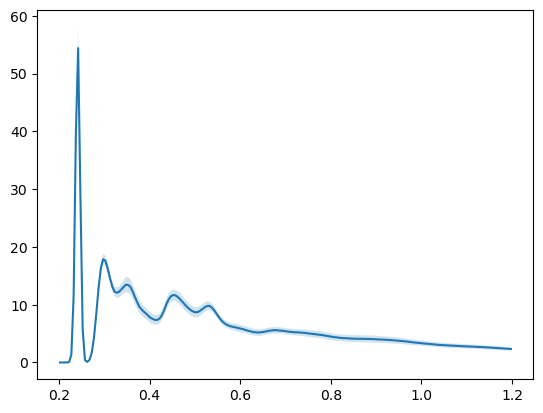

In [29]:
comb = pd.concat(rdf1, axis=1)
ser = np.mean(comb, axis=1)
err = np.std(comb, axis=1)

plt.plot(radii, ser)
plt.fill_between(radii, ser - err, ser + err, alpha=0.2)

## Plotting property comparisons

In [34]:
# defining colors for MD framework (sampled from tab20)
color_set = (
    'blue',
    'orange',
    'green',
    'purple',
    'grey',
)
hues_per_color = 4
cmap = plt.get_cmap('tab20c')

cdict, carr = plotutils.label_discrete_cmap(cmap, color_set, hues_per_color)
dset_colors = {
    'Sage 2.0.0 - ABE10_averaged'   : cdict['blue0'  ],
    'Sage 2.0.0 - Espaloma_AM1BCC'  : cdict['blue2'  ],
    'CHARMM - Mulliken'             : cdict['orange0'],
    'CHARMM-c - Mulliken'           : cdict['orange2'],
    'GAFF - RESP'                   : cdict['green0' ],
    'GAFF2 - RESP'                  : cdict['green2' ],
    'DREIDING - RESP'               : cdict['purple0'],
}

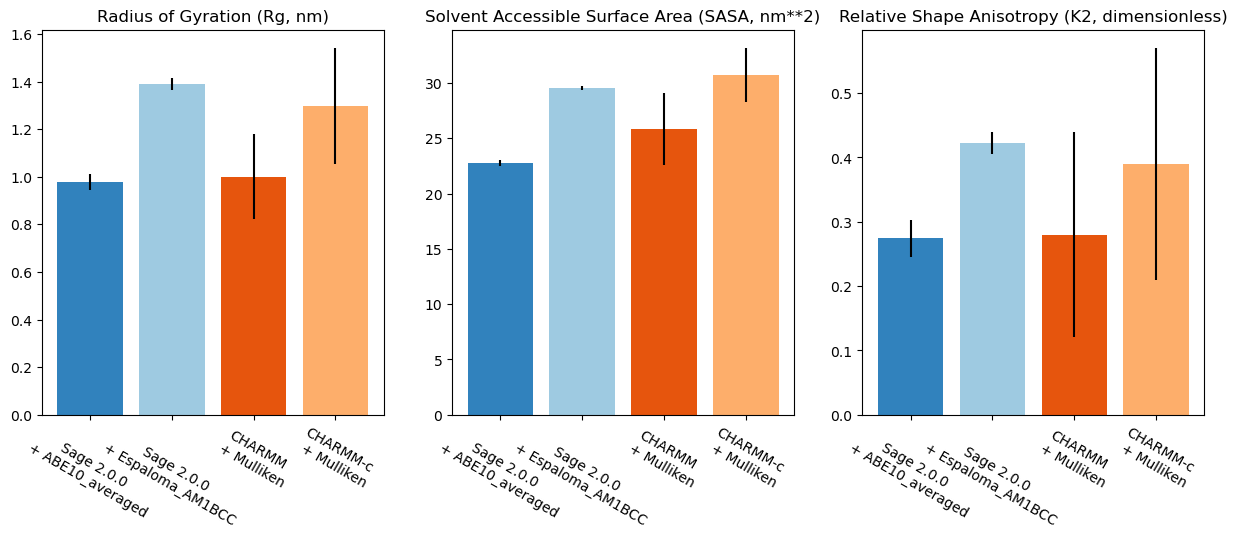

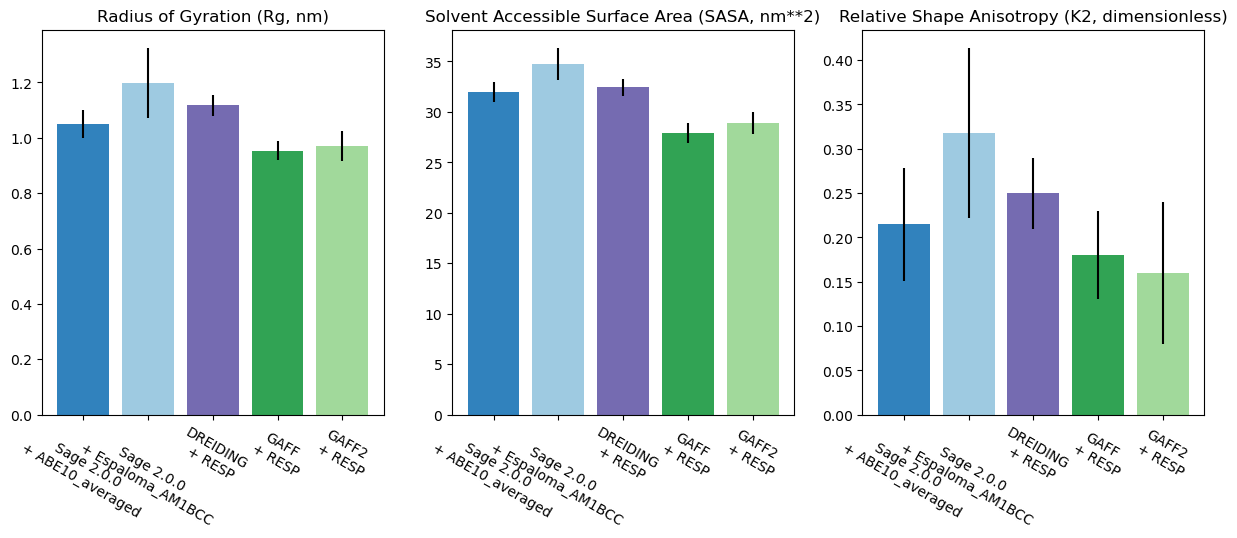

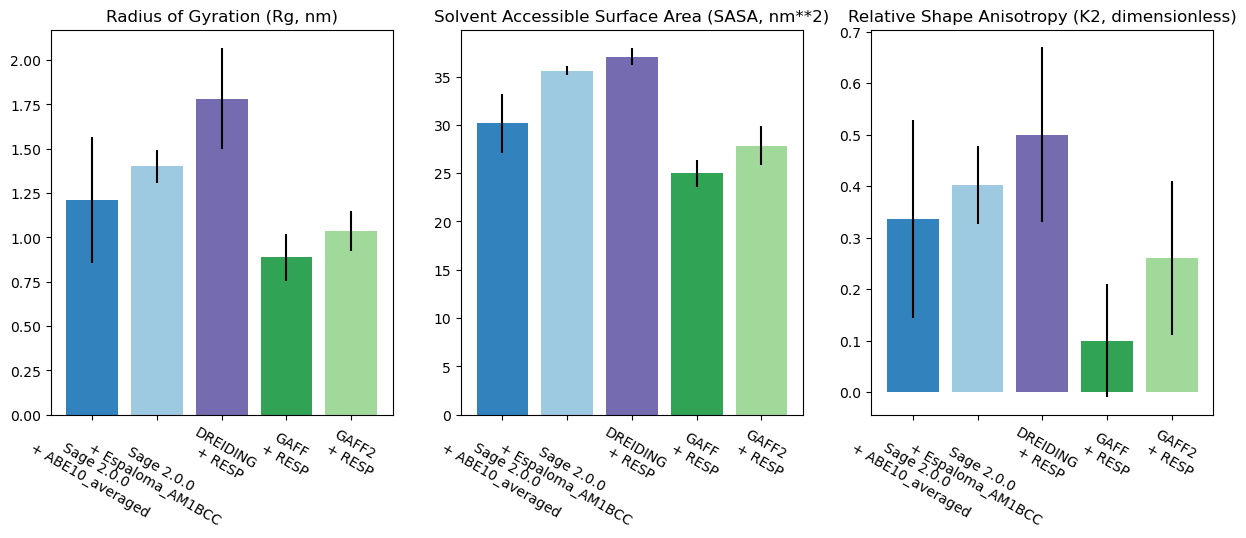

In [38]:
for mol_name in equil_mgr.unique_polymer_names:
    dframe = pd.read_csv(combined_dir / f'{mol_name}.csv', index_col=[0, 1])
    obs = dframe.loc['observables']
    std = dframe.loc['uncertainties']

    frameworks = obs.columns
    num_dsets = len(frameworks)
    num_props = len(obs.index)
    x_pos = np.arange(num_dsets)

    fig, ax = plotutils.presize_subplots(nrows=1, ncols=num_props)
    # fig.suptitle(mol_name)

    for axis, (prop_name, prop_data) in zip(ax.flatten(), obs.iterrows()):
        uncert = std.loc[prop_name].to_numpy()

        axis.set_title(prop_name)
        axis.bar(x_pos, prop_data, yerr=uncert, color=[dset_colors[fr] for fr in frameworks])
        axis.set_xticks(x_pos)
        axis.set_xticklabels([fw.replace(' - ', '\n + ') for fw in obs.columns], rotation=-30)

    fig.savefig(plot_prop_dir / f'{mol_name}_properties.png', bbox_inches='tight')

# Plotting RDFs

## Comparing ABE10 and Espaloma charges

In [ ]:
from ast import literal_eval
import matplotlib.patches as mpl_patches
from matplotlib.colors import Normalize, Colormap
from polysaccharide.general import GREEK_UPPER


def charges_plots(polymer : Polymer, charge_method_1 : str, charge_method_2 : str, n_bins : int=50, fontsize : int=14, orient : Optional[str]=None,
                   cmap : Colormap=plt.get_cmap('turbo'), converter : str='CXSMARTS') -> tuple[tuple[plt.Figure, plt.Axes], tuple[plt.Figure, plt.Axes]]:
    '''For generating charge graphics for paper and resentations'''

    # extracting molecules and computing difference molecule
    chgd_offmol_1 = polymer.charged_offmol_from_sdf(charge_method_1)
    chgd_rdmol_1  = chgd_offmol_1.to_rdkit() # ensure map numbers are present for correct matching
    chgd_rdmol_1  = rdconvert.flattened_rdmol(chgd_rdmol_1, converter=converter) # convert 
    
    chgd_offmol_2 = polymer.charged_offmol_from_sdf(charge_method_2)
    chgd_rdmol_2  = chgd_offmol_2.to_rdkit() # ensure map numbers are present for correct matching
    chgd_rdmol_2  = rdconvert.flattened_rdmol(chgd_rdmol_2, converter=converter) # convert 
    
    diff_rdmol = rdcompare.difference_rdmol(chgd_rdmol_1, chgd_rdmol_2)
    diff_str = f'{GREEK_UPPER["delta"]}q (elem. charge): {charge_method_1} vs {charge_method_2}'

    # generating heatmap
    hm_fig, hm_ax = rdkdraw.rdmol_prop_heatmap_colorscaled( # done in-line to avoid fig and axes from being displayed prematurely
        rdmol=diff_rdmol,
        prop='DeltaPartialCharge',
        cmap=cmap,
        cbar_label='',#diff_str,
        orient=orient
    )

    # Extracting charge differences values and ranges
    deltas = literal_eval(diff_rdmol.GetProp('DeltaPartialCharges'))
    deltas = np.array(deltas)
    vmin, vmax = deltas.min(), deltas.max()
    norm = Normalize(vmin, vmax)

    # generating histogram
    hist_fig, hist_ax = plotutils.presize_subplots(1, 1, scale=8, elongation=4/5)
    bin_vals, bin_edges, patches = hist_ax.hist(deltas, bins=n_bins, orientation='horizontal')

    # coloring histogram bars by atom color map
    for bin_edge, artist in zip(bin_edges, patches):
        plt.setp(artist, 'facecolor', cmap(norm(bin_edge)))

    # computing and labelling charge RMSE
    RMSE = analysis.statistics.RMSE(chgd_offmol_1.partial_charges, chgd_offmol_2.partial_charges)
    labels = [f'RMSE = {round(RMSE.magnitude, 5)} e']
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * len(labels) # create empty handles to pin annotation text to
    hist_ax.legend(handles, labels, loc='best', handlelength=0, fontsize=fontsize)
    # hist_ax.annotate(f'RMSE = {round(RMSE.magnitude, 5)} e', (0.65, 0.9), xycoords='axes fraction', fontsize=14, bbox=dict(edgecolor='black', facecolor='white'))

    # Labelling and sizing axes
    # hist_ax.set_title(f'{polymer.mol_name} charge differences')
    _ = hist_ax.set_yticks((vmin, 0, vmax))
    hist_ax.set_xlabel('Number of atoms', fontsize=fontsize)
    hist_ax.set_ylabel(diff_str, fontsize=fontsize)

    return diff_rdmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax)


class BinSizer(ABC):
    '''Abstract base for auto-sizing histogram bins
    Child class implementations taken from https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width'''
    @abstractstaticmethod
    def num_bins(N : int) -> int:
        raise NotImplementedError

    @classmethod
    @property
    def registry(cls) -> dict[str, 'BinSizer']:
        '''Name-indexed dict of all inherited Component implementations'''
        return {
            subcomp.__name__ : subcomp
                for subcomp in cls.__subclasses__()
        }

class Sturges(BinSizer):
    '''Based on Sturges' Formula'''
    @staticmethod
    def num_bins(N: int) -> int:
        return 1 + ceil(np.log2(N)) 

class Sqrt(BinSizer):
    '''Based on square root'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(np.sqrt(N))

class Rice(BinSizer):
    '''Based on Rice's Rule'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(2 * N**(1/3))

In [ ]:
chg_plot_dir = fig_dir / 'charge_plots'
chg_plot_dir.mkdir(exist_ok=True)

# config options
fs = 12
save = True
# save = False
cvtr = 'CXSMARTS'
cmap = plt.get_cmap('turbo')

# orient = None
orient = 'vertical'

# bin_sizer_type = 'Sturges'
bin_sizer_type = 'Sqrt'
bin_sizer = BinSizer.registry[bin_sizer_type]()

# begin plotting loop
for mol_name, polymer in src_mgr.polymers.items():
    redux_polymer = redux_mgr.polymers[mol_name] # lookup reduction of each polymer
    mol_dir = chg_plot_dir / mol_name
    mol_dir.mkdir(exist_ok=True)

    # reference to ABE10 exact
    n_bins = bin_sizer.num_bins(redux_polymer.n_atoms)
    # print(n_bins)
    diffmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax) = charges_plots(redux_polymer, 'ABE10_exact', 'ABE10_averaged', n_bins=n_bins, fontsize=fs, cmap=cmap, converter=cvtr, orient=orient)
    if save:
        hm_fig.savefig(  mol_dir / f'{mol_name}_redux_heatmap.png', bbox_inches='tight')
        hist_fig.savefig(mol_dir / f'{mol_name}_redux_histogram.png', bbox_inches='tight')

    # RCT vs Espaloma
    n_bins = bin_sizer.num_bins(polymer.n_atoms)
    # print(n_bins)
    diffmol, RMSE, (hm_fig, hm_ax), (hist_fig, hist_ax) = charges_plots(polymer, 'ABE10_averaged', 'Espaloma_AM1BCC', n_bins=n_bins, fontsize=fs, cmap=cmap, converter=cvtr, orient=orient)
    if save:
        hm_fig.savefig(  mol_dir / f'{mol_name}_heatmap.png', bbox_inches='tight')
        hist_fig.savefig(mol_dir / f'{mol_name}_histogram.png', bbox_inches='tight')

# Inspecting PAAm recharging

In [ ]:
p = Path('Reruns') / 'water_soluble_reduced'
rec_mgr = PolymerManager(p)
print(rec_mgr.polymers)

In [ ]:
polymer = rec_mgr.polymers['paam_modified']
polymer.n_atoms

In [ ]:
n = 1_500
for mol_name, polymer in rec_mgr.polymers.items():
    oe_mol = polymer.charged_offmol_from_sdf('ABE10_exact')
    oe_rdmol = oe_mol.to_rdkit()
    rct_mol = polymer.charged_offmol_from_sdf('ABE10_averaged')
    rct_rdmol = rct_mol.to_rdkit()

    diffmol, (fig, ax) = rdcompare.compare_chgd_rdmols(oe_rdmol, rct_rdmol, 'ABE10_exact', 'ABE10_averaged', converter='CXSMARTS', img_size=(n, n))
    RMSE = analysis.statistics.RMSE(oe_mol.partial_charges, rct_mol.partial_charges)
    print(f'{mol_name} RMSE : {round(RMSE, 5)}')
    fig.savefig(f'{mol_name}.png', bbox_inches='tight')

## Generating PNIPAAm conformers for reference

In [ ]:
polymer = rec_mgr.polymers['pnipam_modified']
offmol = polymer.offmol
offmol.generate_conformers(toolkit_registry=ps.TOOLKITS['OpenEye Toolkit'], n_conformers=10)
offmol.to_file('pnipam_confs.pdb', file_format='pdb')

## Performing AM1BCC (no ELF) without conformer gen

In [ ]:
from polysaccharide.charging.application import generate_molecule_charges

polymer = rec_mgr.polymers['paam_modified']
offmol = polymer.offmol

abmol = generate_molecule_charges(polymer.offmol, partial_charge_method='am1bcc', conformers=offmol.conformers)

In [ ]:
plt.plot(abmol.partial_charges)

In [ ]:
rct_mol = polymer.charged_offmol_from_sdf('ABE10_averaged')
rct_rdmol = rct_mol.to_rdkit()
diffmol, (fig, ax) = rdcompare.compare_chgd_rdmols(abmol.to_rdkit(), rct_rdmol, 'AM1BCC (no conf gen)', 'ABE10_averaged', converter='CXSMARTS')

In [ ]:
err_mol = polymer.charged_offmol_from_sdf('ABE10_exact')
err_rdmol = err_mol.to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(err_rdmol, 'PartialCharge', cmap=plt.get_cmap('jet'), cbar_label='AM1-BCC-ELF10 partial charges (e)')

In [ ]:
oemol = abmol.to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(oemol, 'PartialCharge', cmap=plt.get_cmap('jet'), cbar_label='AM1-BCC (original conformer) partial charges (e)')

In [ ]:
from ast import literal_eval

RMSE = analysis.statistics.RMSE(abmol.partial_charges, rct_mol.partial_charges)
print(RMSE)

In [ ]:
list(oemol.GetPropNames())

In [ ]:
chg_method = 'ABE10_exact'

chg_rdmol = polymer.charged_offmol_from_sdf(chg_method).to_rdkit()
rdkdraw.rdmol_prop_heatmap_colorscaled(chg_rdmol, 'PartialCharge', cbar_label='chg_method')